In [2]:
## Implementing the MLP character level model for words by following this paper  https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
## This is the first paper introduced for language modelling with MLP. Let's implement this 

print(
"""
Roughly this paper states that finding the next character using the previous n characters. 

For Example: n=3, xs = "abc", ys = "d" 
             n=5, xs = "abcde", ys = "f" 
"""
)



Roughly this paper states that finding the next character using the previous n characters. 

For Example: n=3, xs = "abc", ys = "d" 
             n=5, xs = "abcde", ys = "f" 



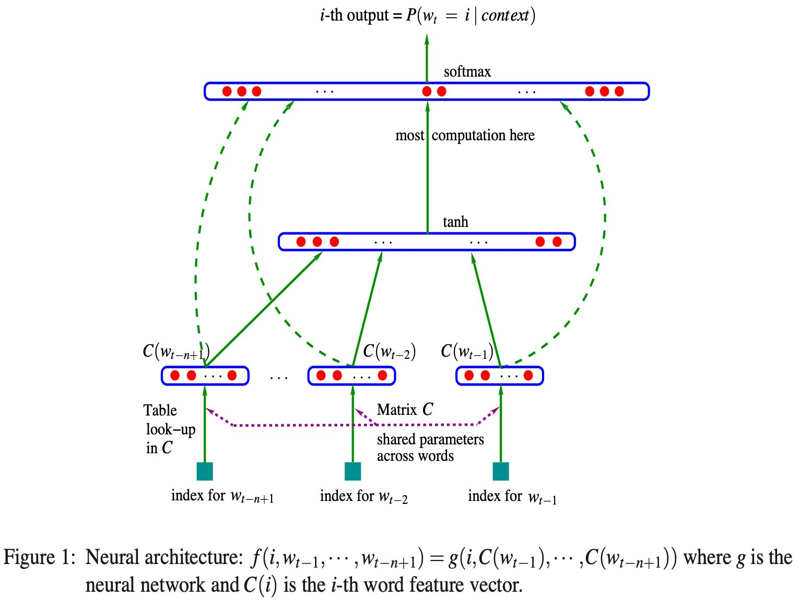

In [39]:
# architecture image 
from PIL import Image 
import urllib

Image.open(urllib.request.urlopen("https://pbs.twimg.com/media/Fhzl42hVUAI9U8V.jpg:large")).resize((800, 600))


# See bottom to top 
## We have 3 layer of input embedding (block size is 3)
## one hidden layer + tanh 
## output layer corresponding to the output size + softamx 

### Note! We are going to implement he neural network based on this architecutre only ;)

In [3]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt

In [4]:
## exploring the dataset 
words = open("names.txt", "r").read().splitlines() 

print(f"Len of words: {len(words)}") 
print(f"Words: {words[:10]}")

## Unique characters
chars = sorted(list(set("".join(words)))) 
print(f"Len of unique characters: {len(chars)}") 

## building encoder, decoder like label2id and id2label 
stoi = { v:k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = { v:k for k, v in stoi.items()}
print(f'Itos:\n{itos}')

Len of words: 32033
Words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Len of unique characters: 26
Itos:
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Building the dataset 
block_size = 3  # Total number of previous characters to predict the next character 

X, Y = [], []  # X is the input to the neural net, Y is the output of the corresponding X to the neural net 
for w in words[:5]: 

    context = [0] * block_size  # if n = 3 [0, 0, 0]
    print(w)
    for ch in w + ".": 
        ix = stoi[ch]

        print(context, ix)
        X.append(context)
        Y.append(ix)

        print("".join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]   # it's like rolling window 

    print("---"*5)

## This code tells us how the single word is converting to character level inputs 

X = torch.tensor(X)
Y = torch.tensor(Y)
print("XShape", X.shape, "YShape", Y.shape)

emma
[0, 0, 0] 5
... ----> e
[0, 0, 5] 13
..e ----> m
[0, 5, 13] 13
.em ----> m
[5, 13, 13] 1
emm ----> a
[13, 13, 1] 0
mma ----> .
---------------
olivia
[0, 0, 0] 15
... ----> o
[0, 0, 15] 12
..o ----> l
[0, 15, 12] 9
.ol ----> i
[15, 12, 9] 22
oli ----> v
[12, 9, 22] 9
liv ----> i
[9, 22, 9] 1
ivi ----> a
[22, 9, 1] 0
via ----> .
---------------
ava
[0, 0, 0] 1
... ----> a
[0, 0, 1] 22
..a ----> v
[0, 1, 22] 1
.av ----> a
[1, 22, 1] 0
ava ----> .
---------------
isabella
[0, 0, 0] 9
... ----> i
[0, 0, 9] 19
..i ----> s
[0, 9, 19] 1
.is ----> a
[9, 19, 1] 2
isa ----> b
[19, 1, 2] 5
sab ----> e
[1, 2, 5] 12
abe ----> l
[2, 5, 12] 12
bel ----> l
[5, 12, 12] 1
ell ----> a
[12, 12, 1] 0
lla ----> .
---------------
sophia
[0, 0, 0] 19
... ----> s
[0, 0, 19] 15
..s ----> o
[0, 19, 15] 16
.so ----> p
[19, 15, 16] 8
sop ----> h
[15, 16, 8] 9
oph ----> i
[16, 8, 9] 1
phi ----> a
[8, 9, 1] 0
hia ----> .
---------------
XShape torch.Size([32, 3]) YShape torch.Size([32])


In [6]:
# Now we have created a input data, let's create an embedding to store this inupts and outputs: 
## Here we have 27 unique characters and we are going to embed in low dimensional space. 

### Let's create a two dimensional embeddings (we are initializing randomly)
C = torch.randn( (27, 2) )  # 27 characters and 2 dimensional embeddings 

### Because it's a random number if you want to get the embedding for character "e", just get the index of "e" is 5 and do the indexing in C C[5] value is the
### -- embedding. Later this embeddings will learned by back-propagation. Initially this is just a random numbers. 

# Embedding of character "e"
print(C[stoi["m"]]) 

tensor([-0.0817, -0.8764])


In [7]:
## But the pytorch indexing is super powerfull, we can give two dimenional array to indexing, it can index. 
## It means we don't need a for loop to iterate over "X"(input), we can just give the "X" to the tensor and we get all the indexed elements.  

emb = C[X]  # X is the input of the model 
print(emb.shape)

## 32 is row of X or len of unique char, 3 is the block size, 2 is the embedding size.   

torch.Size([32, 3, 2])


In [9]:
## Here we are having 2 dimensional space of embedding and block size of 3 | Each character has 2 dimensional embeddings and we are taking 3 character to find the next character so input is 6 
W1 = torch.randn( (emb[0].numel(), 100))  # emb[0].numel():6 = 3 character(blockSize) * 2 size embeddings, 100 is the next layer neuron 
b1 = torch.randn( 100 )


In [24]:
# our aim is multiply emb@W + b but here the shape of emb and W shape is  different. So we can do matric multiplication between those. 
# emb shape: [32, 3, 2], W shape: [6, 100] both are differnet. 
# We need to change or reshape to do perform matrix mul. 
# In emb shape we try to concatenate last 2 shape [32, 3*2] = [32, 6]. Now we can do matrix multiplication 

## 1st way to do this reshaping 
# To do that we need to take all the embeddings separately and combine them. 
## To separate all the embedding dimension separtely we use "torch.unbind(emb, <dim-to-get-separately>)" 
## to combine all this embedding we use "torch.cat((<list-of-tensor-to-combine>), dim = <which-dim-need-to-concatenate>)"

## 2nd way 
# To do that we can simply call the view function to reshape the embeddings 

## 1st way 
hard = torch.cat(torch.unbind(emb, 1), dim = 1)  ## this is in-efficient way to do that

## 2nd way 
easy = emb.view(-1, emb[0].numel())

# comparing the both
# print(hard == easy)

In [47]:
# Let's do the forward pass 

h = torch.tanh( emb.view(-1, emb[0].numel()) @ W1 + b1) # first hidden layer 

## Let's implement 2nd hidden layer (ouput + softmax)

In [97]:
## second hidden layer 
W2 = torch.randn((100, 27))  # 100 is previous layer size  
b2 = torch.randn(27) 

logits = h@W2 + b2  # log of counts 
counts = logits.exp()
prob = counts /counts.sum(dim=1, keepdim=True) 
loss = -prob[torch.arange(32), Y].log().mean()  # negative log likelihood 
print(f"Negative log likelihood: {loss}")


## we can also do this softmax by using the cross_entropy_function in the pytroch 
print(f"Cross-entropy using F.cross_entropy: {F.cross_entropy(logits, Y)}")

Negative log likelihood: 16.18474578857422
Cross-entropy using F.cross_entropy: 16.18474578857422


In [ ]:
""" 
Why F.cross_entropy is good compare to our own implementation ? 

-> First of all it don't create a itermediate tensors, Instead pytorch creates cluster of this operations. 
-> Backword operations is much more easire than our own implementation. 
-> It's more efficient compare to our own implementation. 
----> If the tensor values are [200, 300, 400], applying the exponential function to them results in [-inf, -inf, -inf]
------>  because as the input values increase, the output approaches higher infinity.

"""

In [92]:
prob[torch.arange(32), torch.arange(32)] 

IndexError: index 27 is out of bounds for dimension 1 with size 27

In [91]:
.shape

torch.Size([32])

In [81]:
X.shape

torch.Size([32, 3])